# SVM и его ядра
__Суммарное количество баллов: 10__


В этом задании нам предстоит решить задачу SVM при помощи `cvxopt` и применить ее к искуственным данным. Затем аналогичным способом нужно будет решить задачу ядерного SVM и исследовать его поведение для различных ядер и значений их параметров.

In [1]:
import numpy as np
import copy
from cvxopt import spmatrix, matrix, solvers
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_blobs
from typing import NoReturn, Callable

solvers.options['show_progress'] = False

In [2]:
def visualize(clf, X, y):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_border = (x_max - x_min) / 20 + 1.0e-3
    x_h = (x_max - x_min + 2 * x_border) / 200
    y_border = (y_max - y_min) / 20 + 1.0e-3
    y_h = (y_max - y_min + 2 * y_border) / 200

    cm = plt.cm.Spectral

    xx, yy = np.meshgrid(np.arange(x_min - x_border, x_max + x_border, x_h), np.arange(y_min - y_border, y_max + y_border, y_h))
    mesh = np.c_[xx.ravel(), yy.ravel()]

    z_class = clf.predict(mesh).reshape(xx.shape)

    # Put the result into a color plot
    plt.figure(1, figsize=(8, 8))
    plt.pcolormesh(xx, yy, z_class, cmap=cm, alpha=0.3, shading='gouraud')

    # Plot hyperplane and margin
    z_dist = clf.decision_function(mesh).reshape(xx.shape)
    plt.contour(xx, yy, z_dist, [0.0], colors='black')
    plt.contour(xx, yy, z_dist, [-1.0, 1.0], colors='black', linestyles='dashed')

    # Plot also the training points
    y_pred = clf.predict(X)

    ind_support = []
    ind_correct = []
    ind_incorrect = []
    for i in range(len(y)):
        if i in clf.support:
            ind_support.append(i)
        elif y[i] == y_pred[i]:
            ind_correct.append(i)
        else:
            ind_incorrect.append(i)

    plt.scatter(X[ind_correct, 0], X[ind_correct, 1], c=y[ind_correct], cmap=cm, alpha=1., edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_incorrect, 0], X[ind_incorrect, 1], c=y[ind_incorrect], cmap=cm, alpha=1., marker='*',
               s=50, edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_support, 0], X[ind_support, 1], c=y[ind_support], cmap=cm, alpha=1., edgecolor='yellow', linewidths=1.,
               s=40)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()

In [3]:
def generate_dataset(moons=False):
    if moons:
        X, y = make_moons(1000, noise=0.075, random_state=42)
        return X, 2 * y - 1
    X, y = make_blobs(1000, 2, centers=[[0, 0], [-4, 2], [3.5, -2.0], [3.5, 3.5]], random_state=42)
    y = 2 * (y % 2) - 1
    return X, y
    #return make_classification(1000, 2, 2, 0, flip_y=0.001, class_sep=1.2, scale=0.9, random_state=42)

X, y = generate_dataset(True)

### Задание 1 (4 балла)
Для начала реализуем обычный линейный SVM. 

#### Методы
`fit(X, y)` - обучает SVM, решая задачу оптимизации при помощи `cvxopt.solvers.qp`

`decision_function(X)` - возвращает значение решающей функции (т.е. то число, от которого берем знак с целью узнать класс)

#### Поля
`support` - индексы опорных элементов

In [4]:
from task import LinearSVM

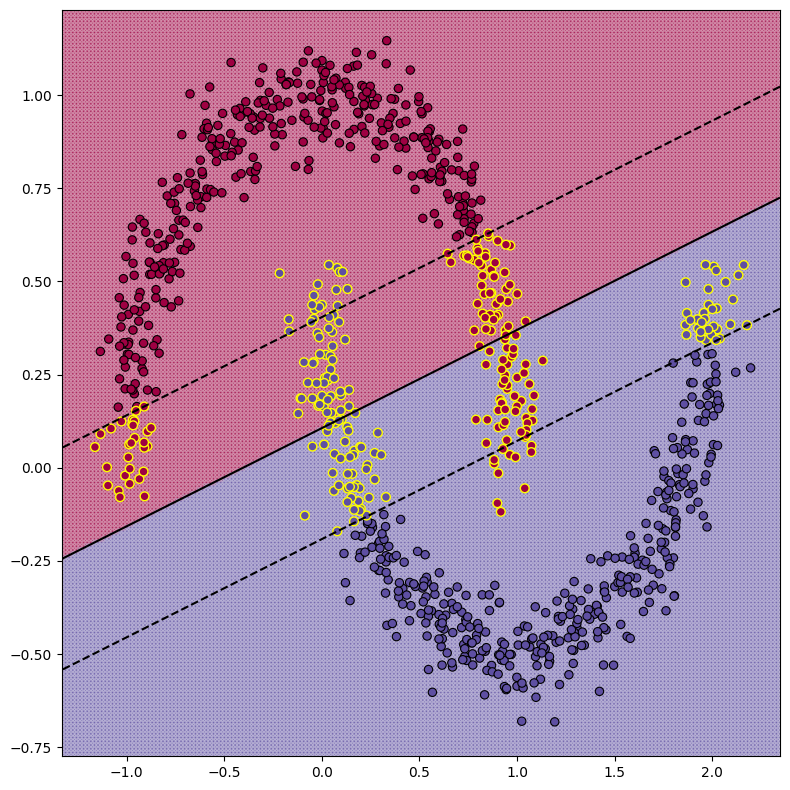

In [5]:
X, y = generate_dataset(True)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

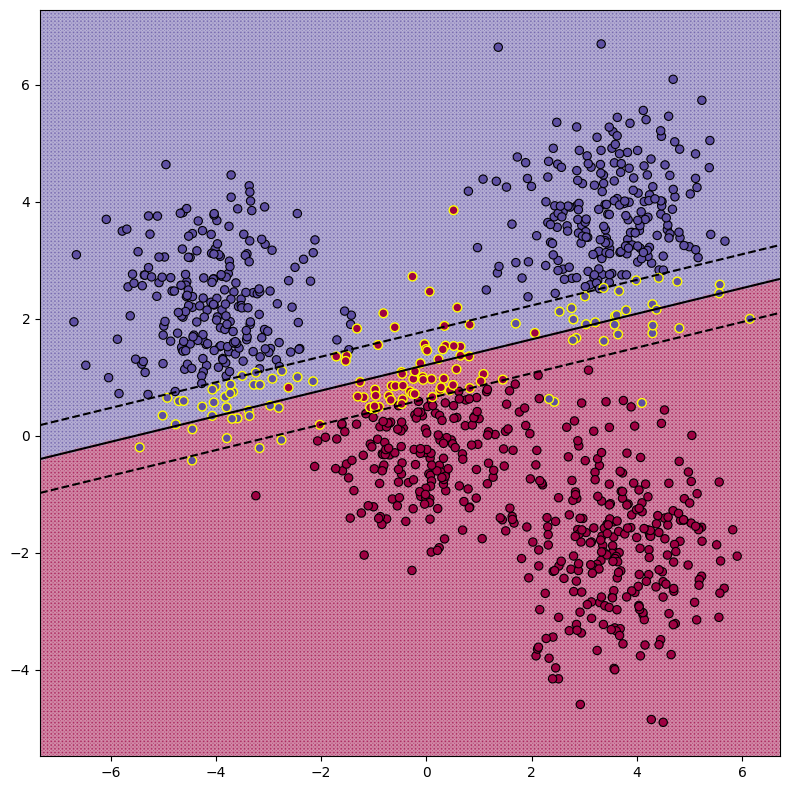

In [6]:
X, y = generate_dataset(False)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

### Задание 2 (2 балла)
Перед реализацией ядерного SVM, реализуем функции, которые строят ядра.

#### Описание
`get_polynomial_kernel(power)` - возвращает полиномиальное ядро с заданной константой и степенью

`get_gaussian_kernel(sigma=1.)` - возвращает ядро Гаусса $k(x, y) = e^{ - \sigma \cdot ||x - y||^2}$ с заданным коэффицинтом сигма

Обратите внимание, что первый аргумент ядра должен иметь размерность `(n, m)`, а второй аргумент `m`. Т.е., первый аргумент - набор векторов, а второй аргумент - вектор.

In [7]:
from task import get_polynomial_kernel, get_gaussian_kernel

### Задание 3 (4 балла)
Теперь перейдем к реализации самого kernel SVM.

#### Описание
`fit(X, y)` - обучает kernel SVM, решая задачу оптимизации при помощи `cvxopt.solvers.qp`

`decision_function(X)` - возвращает значение решающей функции (т.е. то число, от которого берем знак с целью узнать класс)

#### Конструктор
`kernel` - ядро-функция

#### Сведение задачи оптимизации к оптимизации в CVXOpt
Для задачи оптимизации CVXOpt:
$$
\frac{1}{2} \alpha^TP\alpha + q^T\alpha \rightarrow \min\\
G\alpha \leq h\\
A\alpha = b
$$

Сведением двойственной задачи оптимизации SVM будет:

$$
P = [y_iy_jx_i^Tx_j]\\
q = [-1]\\
G = -I\\
h = [0]\\
A = y^T\\
b = 0
$$

При этом опорные вектора отбираются по критерию:

$$
\alpha_i > \epsilon; \epsilon \approx 10^{-5}
$$

In [8]:
from task import KernelSVM

In [9]:
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [ ]:
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

In [ ]:
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

In [ ]:
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()